# 迁移学习

用人家训练好的模型权重参数当做咱们的初始化

一般全连接层需要自己训练，可以选择是否训练别人训练好的特征提取层

In [1]:
import os
import shutil
from shutil import copyfile
import random
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model

In [2]:
base_dir = "./data/PetImages/"

train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'testing')

# 训练集
train_dogs = os.path.join(base_dir, 'training/dogs')
train_cats = os.path.join(base_dir, 'training/cats')

# 测试集
test_dogs = os.path.join(base_dir, 'testing/dogs')
test_cats = os.path.join(base_dir, 'testing/cats')

# tensorflow.kears.applications

存在很多预训练模型

In [3]:
# 导入模型
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
pre_trained_model = ResNet101(input_shape=(75, 75, 3),  # 输入大小
                              include_top=False,        # 不要最后的全连接层
                              weights='imagenet'
                             )

In [7]:
pre_trained_model.input

<KerasTensor: shape=(None, 75, 75, 3) dtype=float32 (created by layer 'input_1')>

In [8]:
# 可以选择训练哪些层
for layer in pre_trained_model.layers:
    # 即所有层的参数均不改变
    layer.trainable=False

# callback的作用

相当于一个监视器，在训练过程中可以设置一些自定义项，比如提前停止，改变学习率等

callback=[

如果连续两个epoch还没降低就停止：
    
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),

可以动态的改变学习率：
    
    tf.keras.callbacks.LearningRateScheduler

保存模型
    
    tf.keras.callbacks.ModelCheckpoint
    
自定义方法
    
    tf.keras.callbacks.Callback

]

In [9]:
# 定义一个callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_en(self, epoch, logs={}):
        if logs.get('accuracy')>0.95:
            print("the train accuracy is > 95")
            self.model.stop_training = True

In [10]:
from tensorflow.keras.optimizers import Adam

In [11]:
# 为全连接层做准备
x = layers.Flatten()(pre_trained_model.output)
# 加入全连接层，这个需要从头训练的
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
# 输出层
x = layers.Dense(1, activation='sigmoid')(x)
# 构建模型序列
model = Model(pre_trained_model.input, x)

model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

In [16]:
pre_trained_model.input.__dict__

{'_type_spec': TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='input_1'),
 '_inferred_value': None,
 '_name': 'input_1',
 '_keras_mask': None,
 '_keras_history': KerasHistory(layer=<keras.engine.input_layer.InputLayer object at 0x000002C24F8D53A0>, node_index=0, tensor_index=0)}

In [15]:
x.__dict__

{'_type_spec': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None),
 '_inferred_value': None,
 '_name': 'dense_1/Sigmoid:0',
 '_keras_history': KerasHistory(layer=<keras.layers.core.dense.Dense object at 0x000002C2685B6B80>, node_index=0, tensor_index=0)}

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir, # 文件夹路径
    target_size=(75, 75), # 指定resize层的大小
    batch_size=20,
    # 如果one_hot就是categorical，二分类用binary就可以
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, # 文件夹路径
    target_size=(75, 75), # 指定resize层的大小
    batch_size=20,
    # 如果one_hot就是categorical，二分类用binary就可以
    class_mode='binary'
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# 训练模型

加入callback模块

In [11]:
callbacks = myCallback()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=300,
    epochs=100,
    validation_data=test_generator,
    validation_steps=100,
    verbose=2,
    callbacks=callbacks
)

Epoch 1/100
300/300 - 185s - loss: 0.7264 - accuracy: 0.5433 - val_loss: 0.6465 - val_accuracy: 0.6275
Epoch 2/100
300/300 - 182s - loss: 0.6942 - accuracy: 0.5630 - val_loss: 0.6561 - val_accuracy: 0.6195
Epoch 3/100
300/300 - 182s - loss: 0.6855 - accuracy: 0.5550 - val_loss: 0.6409 - val_accuracy: 0.6605
Epoch 4/100
300/300 - 186s - loss: 0.6748 - accuracy: 0.5894 - val_loss: 0.6461 - val_accuracy: 0.6455
Epoch 5/100
300/300 - 188s - loss: 0.6708 - accuracy: 0.5852 - val_loss: 0.6516 - val_accuracy: 0.6010
Epoch 6/100
300/300 - 189s - loss: 0.6628 - accuracy: 0.5972 - val_loss: 0.6359 - val_accuracy: 0.6370
Epoch 7/100
300/300 - 186s - loss: 0.6708 - accuracy: 0.5865 - val_loss: 0.6695 - val_accuracy: 0.5695
Epoch 8/100
300/300 - 191s - loss: 0.6674 - accuracy: 0.5917 - val_loss: 0.6363 - val_accuracy: 0.6470
Epoch 9/100
300/300 - 196s - loss: 0.6623 - accuracy: 0.5950 - val_loss: 0.6237 - val_accuracy: 0.6645
Epoch 10/100
300/300 - 188s - loss: 0.6583 - accuracy: 0.6085 - val_loss:

Epoch 80/100
300/300 - 182s - loss: 0.6361 - accuracy: 0.6340 - val_loss: 0.5864 - val_accuracy: 0.6905
Epoch 81/100
300/300 - 182s - loss: 0.6313 - accuracy: 0.6360 - val_loss: 0.6012 - val_accuracy: 0.6815
Epoch 82/100
300/300 - 183s - loss: 0.6332 - accuracy: 0.6442 - val_loss: 0.5978 - val_accuracy: 0.6870
Epoch 83/100
300/300 - 182s - loss: 0.6233 - accuracy: 0.6572 - val_loss: 0.6037 - val_accuracy: 0.6780
Epoch 84/100
300/300 - 181s - loss: 0.6323 - accuracy: 0.6435 - val_loss: 0.5855 - val_accuracy: 0.6935
Epoch 85/100
300/300 - 183s - loss: 0.6271 - accuracy: 0.6422 - val_loss: 0.5972 - val_accuracy: 0.6815
Epoch 86/100
300/300 - 182s - loss: 0.6319 - accuracy: 0.6403 - val_loss: 0.6089 - val_accuracy: 0.6660
Epoch 87/100
300/300 - 182s - loss: 0.6231 - accuracy: 0.6438 - val_loss: 0.6435 - val_accuracy: 0.6335
Epoch 88/100
300/300 - 182s - loss: 0.6338 - accuracy: 0.6418 - val_loss: 0.5907 - val_accuracy: 0.6855
Epoch 89/100
300/300 - 182s - loss: 0.6289 - accuracy: 0.6459 - 

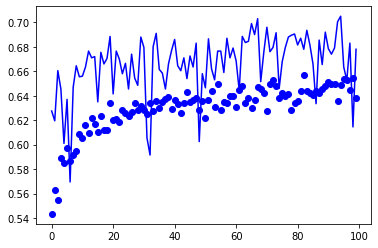

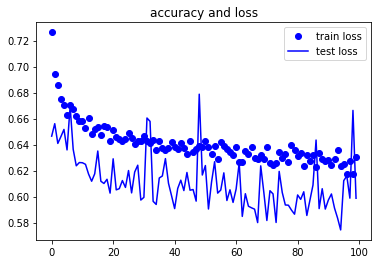

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, "bo", label='train accuracy')
plt.plot(epochs, val_acc, 'b', label='test accuracy')

plt.figure()
plt.plot(epochs, loss, "bo", label='train loss')
plt.plot(epochs, val_loss, 'b', label='test loss')

plt.title('accuracy and loss')
plt.legend()
plt.show()

In [13]:
pre_trained_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 81, 81, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 38, 38, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 38, 38, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [14]:
# last_layer = pre_trained_model.get_layer('conv2_block3_out')
# last_layer = pre_trained_model.get_layer(index=35)

# ResNet50

In [15]:
pre_trained_model_50 = ResNet50(input_shape=(75, 75, 3),  # 输入大小
                              include_top=False,        # 不要最后的全连接层
                              weights='imagenet'
                             )
# 可以选择训练哪些层
for layer in pre_trained_model_50.layers:
    # 即所有层的参数均不改变
    layer.trainable=False

In [16]:
# 为全连接层做准备
x1 = layers.Flatten()(pre_trained_model_50.output)
# 加入全连接层，这个需要从头训练的
x1 = layers.Dense(1024, activation='relu')(x1)
x1 = layers.Dropout(0.2)(x1)
# 输出层
x1 = layers.Dense(1, activation='sigmoid')(x1)
# 构建模型序列
model_50 = Model(pre_trained_model_50.input, x1)

model_50.compile(optimizer=Adam(lr=1e-4),
                 loss='binary_crossentropy',
                 metrics=['accuracy']
                )

In [17]:
history50 = model_50.fit_generator(
    train_generator,
    steps_per_epoch=300,
    epochs=100,
    validation_data=test_generator,
    validation_steps=100,
    verbose=2,
    callbacks=callbacks
)

Epoch 1/100
300/300 - 113s - loss: 0.7253 - accuracy: 0.5343 - val_loss: 0.6532 - val_accuracy: 0.6220
Epoch 2/100
300/300 - 110s - loss: 0.6838 - accuracy: 0.5692 - val_loss: 0.6437 - val_accuracy: 0.6430
Epoch 3/100
300/300 - 110s - loss: 0.6783 - accuracy: 0.5735 - val_loss: 0.6356 - val_accuracy: 0.6670
Epoch 4/100
300/300 - 110s - loss: 0.6698 - accuracy: 0.5932 - val_loss: 0.6355 - val_accuracy: 0.6600
Epoch 5/100
300/300 - 110s - loss: 0.6631 - accuracy: 0.5959 - val_loss: 0.6349 - val_accuracy: 0.6430
Epoch 6/100
300/300 - 110s - loss: 0.6604 - accuracy: 0.6083 - val_loss: 0.6282 - val_accuracy: 0.6610
Epoch 7/100
300/300 - 110s - loss: 0.6576 - accuracy: 0.6125 - val_loss: 0.6220 - val_accuracy: 0.6785
Epoch 8/100
300/300 - 111s - loss: 0.6523 - accuracy: 0.6147 - val_loss: 0.6218 - val_accuracy: 0.6725
Epoch 9/100
300/300 - 110s - loss: 0.6531 - accuracy: 0.6128 - val_loss: 0.6156 - val_accuracy: 0.6750
Epoch 10/100
300/300 - 110s - loss: 0.6611 - accuracy: 0.6035 - val_loss:

Epoch 80/100
300/300 - 111s - loss: 0.6164 - accuracy: 0.6605 - val_loss: 0.5861 - val_accuracy: 0.6970
Epoch 81/100
300/300 - 111s - loss: 0.6275 - accuracy: 0.6488 - val_loss: 0.5887 - val_accuracy: 0.6890
Epoch 82/100
300/300 - 111s - loss: 0.6295 - accuracy: 0.6433 - val_loss: 0.5855 - val_accuracy: 0.6985
Epoch 83/100
300/300 - 111s - loss: 0.6257 - accuracy: 0.6540 - val_loss: 0.6047 - val_accuracy: 0.6830
Epoch 84/100
300/300 - 111s - loss: 0.6191 - accuracy: 0.6565 - val_loss: 0.5870 - val_accuracy: 0.6900
Epoch 85/100
300/300 - 111s - loss: 0.6251 - accuracy: 0.6458 - val_loss: 0.6087 - val_accuracy: 0.6800
Epoch 86/100
300/300 - 111s - loss: 0.6193 - accuracy: 0.6517 - val_loss: 0.6642 - val_accuracy: 0.6240
Epoch 87/100
300/300 - 111s - loss: 0.6283 - accuracy: 0.6413 - val_loss: 0.5803 - val_accuracy: 0.6945
Epoch 88/100
300/300 - 112s - loss: 0.6249 - accuracy: 0.6545 - val_loss: 0.6183 - val_accuracy: 0.6550
Epoch 89/100
300/300 - 111s - loss: 0.6187 - accuracy: 0.6553 - 

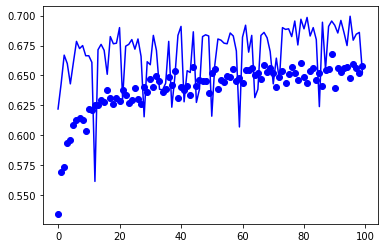

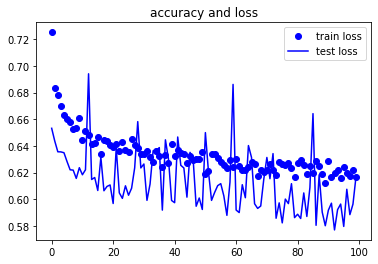

In [18]:
import matplotlib.pyplot as plt
acc = history50.history['accuracy']
val_acc = history50.history['val_accuracy']
loss = history50.history['loss']
val_loss = history50.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, "bo", label='train accuracy')
plt.plot(epochs, val_acc, 'b', label='test accuracy')

plt.figure()
plt.plot(epochs, loss, "bo", label='train loss')
plt.plot(epochs, val_loss, 'b', label='test loss')

plt.title('accuracy and loss')
plt.legend()
plt.show()

# InceptionV3

In [19]:
pre_trained_model_v3 = InceptionV3(input_shape=(75, 75, 3),  # 输入大小
                                   include_top=False,        # 不要最后的全连接层
                                   weights='imagenet'
                                  )
# 可以选择训练哪些层
for layer in pre_trained_model_v3.layers:
    # 即所有层的参数均不改变
    layer.trainable=False

In [20]:
# 为全连接层做准备
x2 = layers.Flatten()(pre_trained_model_v3.output)
# 加入全连接层，这个需要从头训练的
x2 = layers.Dense(1024, activation='relu')(x2)
x2 = layers.Dropout(0.2)(x2)
# 输出层
x2 = layers.Dense(1, activation='sigmoid')(x2)
# 构建模型序列
model_v3 = Model(pre_trained_model_v3.input, x2)

model_v3.compile(optimizer=Adam(lr=1e-4),
                 loss='binary_crossentropy',
                 metrics=['accuracy']
                )

In [21]:
history_v3 = model_v3.fit_generator(
    train_generator,
    steps_per_epoch=300,
    epochs=100,
    validation_data=test_generator,
    validation_steps=100,
    verbose=2,
    callbacks=callbacks
)

Epoch 1/100
300/300 - 50s - loss: 0.6208 - accuracy: 0.6789 - val_loss: 0.4558 - val_accuracy: 0.7820
Epoch 2/100
300/300 - 46s - loss: 0.5616 - accuracy: 0.7172 - val_loss: 0.4477 - val_accuracy: 0.7915
Epoch 3/100
300/300 - 46s - loss: 0.5259 - accuracy: 0.7393 - val_loss: 0.4596 - val_accuracy: 0.7870
Epoch 4/100
300/300 - 46s - loss: 0.5357 - accuracy: 0.7338 - val_loss: 0.4221 - val_accuracy: 0.8050
Epoch 5/100
300/300 - 46s - loss: 0.5182 - accuracy: 0.7412 - val_loss: 0.4224 - val_accuracy: 0.8025
Epoch 6/100
300/300 - 46s - loss: 0.5053 - accuracy: 0.7483 - val_loss: 0.4358 - val_accuracy: 0.7935
Epoch 7/100
300/300 - 46s - loss: 0.5022 - accuracy: 0.7497 - val_loss: 0.4190 - val_accuracy: 0.8050
Epoch 8/100
300/300 - 46s - loss: 0.5043 - accuracy: 0.7481 - val_loss: 0.4339 - val_accuracy: 0.7970
Epoch 9/100
300/300 - 46s - loss: 0.5005 - accuracy: 0.7532 - val_loss: 0.4268 - val_accuracy: 0.7950
Epoch 10/100
300/300 - 46s - loss: 0.4866 - accuracy: 0.7560 - val_loss: 0.4469 - 

Epoch 81/100
300/300 - 46s - loss: 0.4351 - accuracy: 0.7909 - val_loss: 0.3721 - val_accuracy: 0.8305
Epoch 82/100
300/300 - 45s - loss: 0.4247 - accuracy: 0.7979 - val_loss: 0.3619 - val_accuracy: 0.8365
Epoch 83/100
300/300 - 45s - loss: 0.4265 - accuracy: 0.7985 - val_loss: 0.3832 - val_accuracy: 0.8250
Epoch 84/100
300/300 - 45s - loss: 0.4246 - accuracy: 0.7965 - val_loss: 0.3713 - val_accuracy: 0.8315
Epoch 85/100
300/300 - 45s - loss: 0.4332 - accuracy: 0.7924 - val_loss: 0.3743 - val_accuracy: 0.8295
Epoch 86/100
300/300 - 45s - loss: 0.4216 - accuracy: 0.7988 - val_loss: 0.3727 - val_accuracy: 0.8260
Epoch 87/100
300/300 - 45s - loss: 0.4218 - accuracy: 0.7974 - val_loss: 0.3684 - val_accuracy: 0.8340
Epoch 88/100
300/300 - 45s - loss: 0.4262 - accuracy: 0.7983 - val_loss: 0.3831 - val_accuracy: 0.8290
Epoch 89/100
300/300 - 45s - loss: 0.4342 - accuracy: 0.7915 - val_loss: 0.3729 - val_accuracy: 0.8330
Epoch 90/100
300/300 - 45s - loss: 0.4334 - accuracy: 0.7918 - val_loss: 

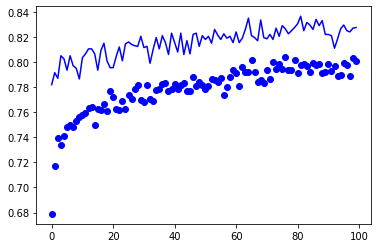

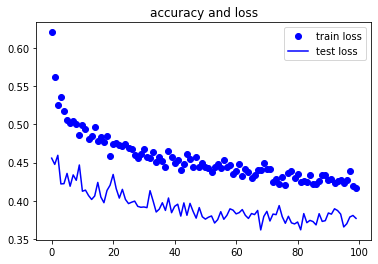

In [22]:
import matplotlib.pyplot as plt
acc = history_v3.history['accuracy']
val_acc = history_v3.history['val_accuracy']
loss = history_v3.history['loss']
val_loss = history_v3.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, "bo", label='train accuracy')
plt.plot(epochs, val_acc, 'b', label='test accuracy')

plt.figure()
plt.plot(epochs, loss, "bo", label='train loss')
plt.plot(epochs, val_loss, 'b', label='test loss')

plt.title('accuracy and loss')
plt.legend()
plt.show()